# 导入相关的包

In [1]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

%matplotlib inline

# 设置工作路径

In [2]:
import os
os.chdir("D:/data")

# 读取数据

In [4]:
df = pd.read_excel('Online Retail.xlsx')

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# 查看数据集的基本信息

In [6]:
#大小
df.shape

(541909, 8)

In [7]:
#客户数量
df.CustomerID.unique().shape

(4373,)

# 生成RFM特征，并进行基本分析

In [8]:
#时间格式调整
df['invdatetime'] = pd.to_datetime(df.InvoiceDate)

In [9]:
#购买商品数量
df.Quantity.describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [10]:
#商品单价
df.UnitPrice.describe()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

In [11]:
# 选择英国的数据
df = df[df.Country == 'United Kingdom']

# 计算每单价格（单价*数量）
df['amount'] = df.Quantity*df.UnitPrice

# 移除交易为负的交易（异常值）或者ID为空的客户
df = df[~(df.amount<0)]
df.head()
df = df[~(df.CustomerID.isnull())]

In [12]:
df.shape

(354345, 10)

# 构造 Recency 特征

In [13]:
df.InvoiceDate.max()

Timestamp('2011-12-09 12:49:00')

In [14]:
df.InvoiceDate.min()

Timestamp('2010-12-01 08:26:00')

In [15]:
refrence_date = df.InvoiceDate.max()
#多加了一天
refrence_date = refrence_date + datetime.timedelta(days = 1)

In [18]:
df['refrence_date']=refrence_date
df['days_since_last_purchase'] = refrence_date - df.InvoiceDate
df['days_since_last_purchase_num'] = df['days_since_last_purchase'].astype('timedelta64[D]')


In [19]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,invdatetime,amount,days_since_last_purchase,days_since_last_purchase_num,refrence_date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,15.30,374 days 04:23:00,374.0,2011-12-10 12:49:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,20.34,374 days 04:23:00,374.0,2011-12-10 12:49:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01 08:26:00,22.00,374 days 04:23:00,374.0,2011-12-10 12:49:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,20.34,374 days 04:23:00,374.0,2011-12-10 12:49:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,20.34,374 days 04:23:00,374.0,2011-12-10 12:49:00


In [22]:
customer_history_df = df.groupby("CustomerID").min().reset_index()[['CustomerID', 'days_since_last_purchase_num']]
customer_history_df.rename(columns={'days_since_last_purchase_num':'recency'}, inplace=True)


In [23]:
customer_history_df.head()

,CustomerID,recency
0,12346.0,326.0
1,12747.0,2.0
2,12748.0,1.0
3,12749.0,4.0
4,12820.0,3.0


In [25]:
customer_history_df['recency'].describe()

count    3921.000000
mean       92.188472
std        99.528995
min         1.000000
25%        18.000000
50%        51.000000
75%       143.000000
max       374.000000
Name: recency, dtype: float64

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


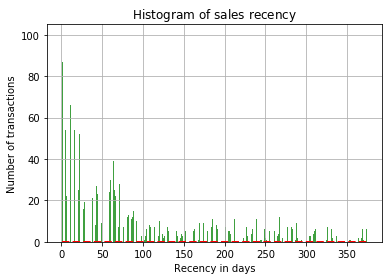

In [26]:
x = customer_history_df.recency
mu = np.mean(customer_history_df.recency)
sigma = math.sqrt(np.var(customer_history_df.recency))
n, bins, patches = plt.hist(x, 1000, facecolor='green', alpha=0.75)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('Recency in days')
plt.ylabel('Number of transactions')
plt.title(r'$\mathrm{Histogram\ of\ sales\ recency}\ $')
plt.grid(True)

# 构造 Frequency 和 Monetary value 特征

In [27]:
customer_monetary_val = df[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val, how='outer')
customer_history_df.amount = customer_history_df.amount+0.001


In [28]:
customer_freq = df[['CustomerID', 'amount']].groupby("CustomerID").count().reset_index()
customer_freq.rename(columns={'amount':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq, how='outer')

In [29]:
customer_history_df.head()

,CustomerID,recency,amount,frequency
0,12346.0,326.0,77183.601,1
1,12747.0,2.0,4196.011,103
2,12748.0,1.0,33719.731,4596
3,12749.0,4.0,4090.881,199
4,12820.0,3.0,942.341,59


In [38]:
#from sklearn import preprocessing
import math

customer_history_df['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)
customer_history_df['amount_log'] = customer_history_df['amount'].apply(math.log)
feature_vector = ['amount_log', 'recency_log','frequency_log']
X_subset = customer_history_df[feature_vector].as_matrix()
#scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = X_subset

D:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


# 查看 Recency vs Monetary Value 的关系(取对数后)

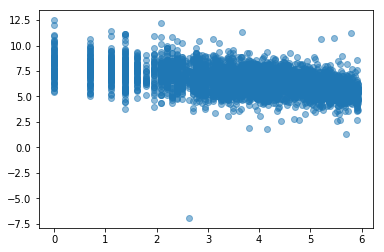

In [33]:
plt.scatter(customer_history_df.recency_log, customer_history_df.amount_log, alpha=0.5)

# 查看 Monetary Value 分布 (取对数后)

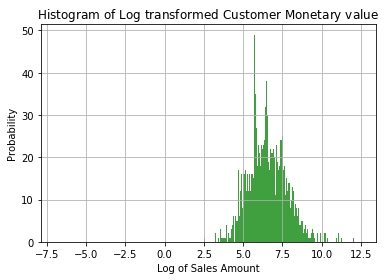

In [34]:
x = customer_history_df.amount_log
n, bins, patches = plt.hist(x, 1000, facecolor='green', alpha=0.75)

plt.xlabel('Log of Sales Amount')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ Log\ transformed\ Customer\ Monetary\ value}\ $')
plt.grid(True)
#plt.show()

In [35]:
customer_history_df.head()

,CustomerID,recency,amount,frequency,recency_log,frequency_log,amount_log
0,12346.0,326.0,77183.601,1,5.786897,0.000000,11.253942
1,12747.0,2.0,4196.011,103,0.693147,4.634729,8.341890
2,12748.0,1.0,33719.731,4596,0.000000,8.432942,10.425838
3,12749.0,4.0,4090.881,199,1.386294,5.293305,8.316516
4,12820.0,3.0,942.341,59,1.098612,4.077537,6.848367


Text(0.5,0,'Monetary')

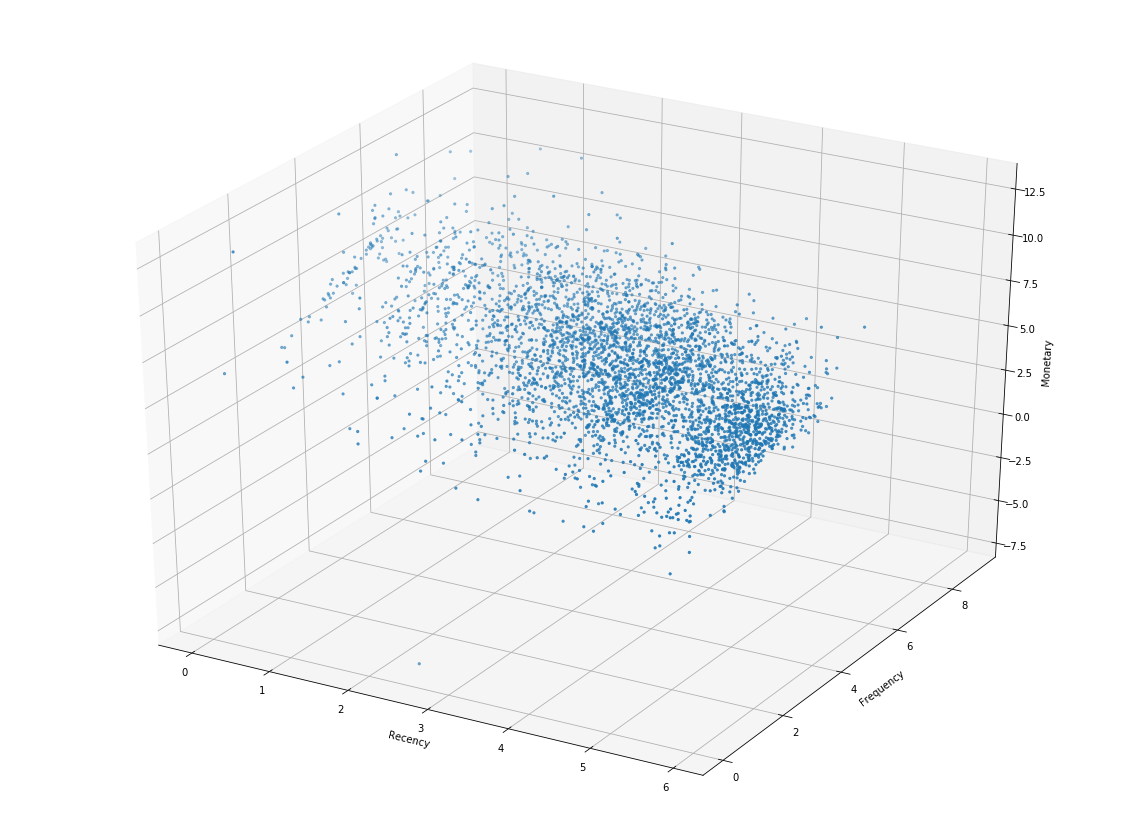

In [36]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

xs =customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.amount_log
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

#plt.show()

# 利用k-means算法进行客户细分

In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

X = X_scaled

cluster_centers = dict()

for n_clusters in range(3,6,2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    #ax2 = plt.subplot(111, projection='3d')
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    cluster_centers.update({n_clusters :{
                                        'cluster_center':clusterer.cluster_centers_,
                                        'silhouette_score':silhouette_avg,
                                        'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    feature1 = 0
    feature2 = 2
    ax2.scatter(X[:, feature1], X[:, feature2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, feature1], centers[:, feature2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[feature1], c[feature2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature i.e. monetary value")
    ax2.set_ylabel("Feature space for the 2nd feature i.e. frequency")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    #plt.show()

ModuleNotFoundError: No module named 'sklearn.utils._show_versions'

In [35]:
for i in range(3,6,2):
    print("for {} number of clusters".format(i))
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=feature_vector))
    print("Silhouette score for cluster {} is {}". format(i, cluster_centers[i]['silhouette_score']))
    print()

for 3 number of clusters
    amount_log  recency_log  frequency_log
0   843.937271    44.083222      53.920633
1   221.236034   121.766072      10.668661
2  3159.294272     7.196647     177.789098
Silhouette score for cluster 3 is 0.30437444714898737

for 5 number of clusters
    amount_log  recency_log  frequency_log
0  3905.544371     5.627973     214.465989
1  1502.519606    46.880212      92.306262
2   142.867249   126.546751       5.147370
3   408.235418   139.056216      25.530424
4   464.371885    13.386419      29.581298
Silhouette score for cluster 5 is 0.27958641427323727



# 把类别节点增加到原始数据框

In [36]:
labels = cluster_centers[5]['labels']   
customer_history_df['num_cluster5_labels'] = labels
labels = cluster_centers[3]['labels']
customer_history_df['num_cluster3_labels'] = labels

In [37]:
customer_history_df.head()

,CustomerID,recency,amount,frequency,recency_log,frequency_log,amount_log,num_cluster5_labels,num_cluster3_labels
0,12346.0,326.0,77183.601,1,5.786897,0.000000,11.253942,1,0
1,12747.0,2.0,4196.011,103,0.693147,4.634729,8.341890,0,2
2,12748.0,1.0,33719.731,4596,0.000000,8.432942,10.425838,0,2
3,12749.0,4.0,4090.881,199,1.386294,5.293305,8.316516,0,2
4,12820.0,3.0,942.341,59,1.098612,4.077537,6.848367,4,2
